🔥 [Start] 템플릿 기반 바나나 특가 광고 제작

🚀 [Phase 1] 'image.png' 누끼 작업...

🚀 [Phase 2] 레이아웃 가이드 작성...

🚀 [Phase 3] Flux AI 스타일링 (글자 없이 배경만)...


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.87it/s]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
100%|██████████| 18/18 [00:45<00:00,  2.51s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.



🚀 [Phase 4] 최종 텍스트 디자인 및 합성...


/tmp/ipykernel_5795/3323733086.py:47: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5795/3323733086.py:47: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5795/3323733086.py:47: UserWarning: Glyph 45572 (\N{HANGUL SYLLABLE NU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5795/3323733086.py:47: UserWarning: Glyph 45180 (\N{HANGUL SYLLABLE GGI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5795/3323733086.py:47: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5795/3323733086.py:47: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5795/3323733086.py:47: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


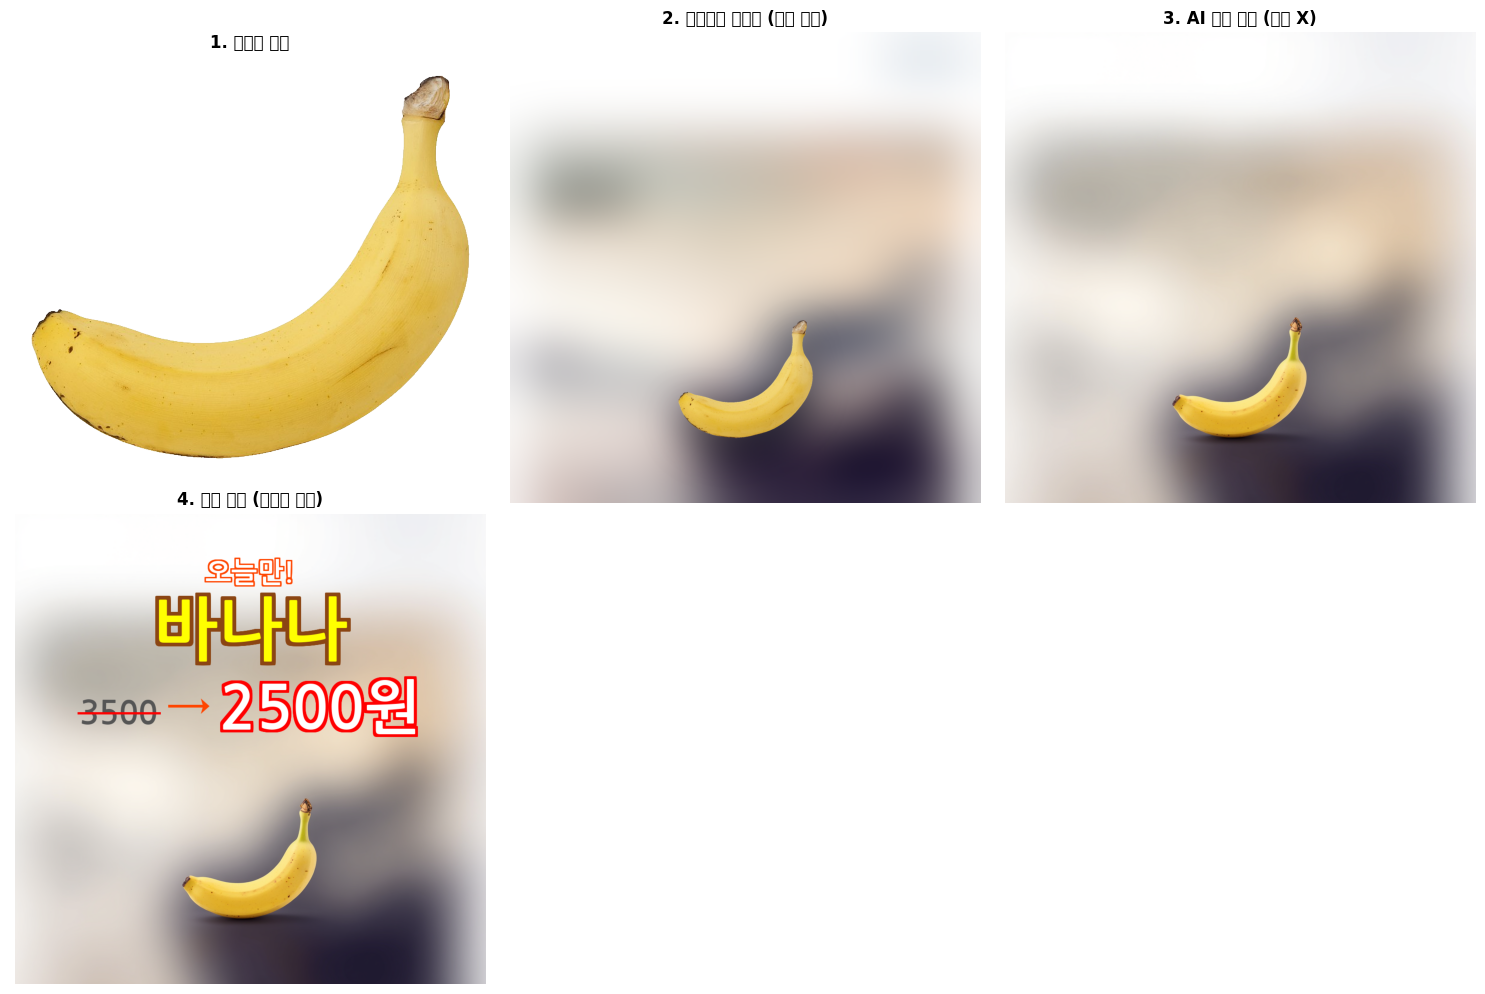


✅ 모든 작업 완료! 'final_banana_sale_ad.png' 파일을 확인하세요.


In [3]:
import torch
import gc
import os
import requests
import numpy as np
import math
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps
from torchvision import transforms
from transformers import AutoModelForImageSegmentation, BitsAndBytesConfig
from diffusers import FluxImg2ImgPipeline, FluxTransformer2DModel
from diffusers.utils import load_image
import matplotlib.pyplot as plt

# ==========================================
# ⚙️ 설정 & 헬퍼 함수
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16 
MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev"
}

def flush():
    gc.collect()
    torch.cuda.empty_cache()

def download_font(font_name="NanumGothicBold.ttf"):
    if not os.path.exists(font_name):
        # 나눔고딕 볼드 (상업적 무료)
        url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

def plot_steps(step_images):
    n = len(step_images)
    cols = 3
    rows = math.ceil(n / cols)
    plt.figure(figsize=(15, 5 * rows))
    for i, (img, title) in enumerate(step_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(title, fontsize=12, fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ==========================================
# [Phase 1] 바나나 누끼 따기 (BiRefNet)
# ==========================================
def run_segmentation(image_path):
    print(f"\n🚀 [Phase 1] '{image_path}' 누끼 작업...")
    flush()
    model = AutoModelForImageSegmentation.from_pretrained(MODEL_IDS["SEG"], trust_remote_code=True)
    model.to(DEVICE)
    model.eval()
    
    img = load_image(image_path).convert("RGB")
    W, H = img.size
    target_size = (1024, 1024)
    img_resized = img.resize(target_size, Image.LANCZOS)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform(img_resized).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        preds = model(input_tensor)[-1].sigmoid().cpu()
    
    pred = preds[0].squeeze()
    mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
    mask = mask.point(lambda x: 255 if x > 120 else 0)
    
    fg = img.copy()
    fg.putalpha(mask)
    
    del model, input_tensor
    flush()
    return fg

# ==========================================
# [Phase 2] 템플릿 기반 레이아웃 가이드 작성
# ==========================================
def create_layout_guide(fg_banana, template_path="template.png"):
    print("\n🚀 [Phase 2] 레이아웃 가이드 작성...")
    
    # 템플릿 이미지가 없으면 노란색 단색 배경 사용
    if os.path.exists(template_path):
        bg = load_image(template_path).convert("RGB").resize((1024, 1024))
        # 템플릿의 기존 글자를 지우기 위해 블러 처리 (AI가 헷갈리지 않게)
        bg = bg.filter(ImageFilter.GaussianBlur(radius=50))
    else:
        print("⚠️ template.png가 없습니다. 기본 노란색 배경을 사용합니다.")
        bg = Image.new("RGB", (1024, 1024), "#FFD700") # 밝은 노랑
        
    bg_w, bg_h = bg.size
    fg_w, fg_h = fg_banana.size
    
    # 바나나 크기 및 위치 조정 (템플릿 하단 중앙에 배치)
    scale = 0.4 # 바나나 크기 조절
    new_w, new_h = int(fg_w * scale), int(fg_h * scale)
    fg_resized = fg_banana.resize((new_w, new_h), Image.LANCZOS)
    
    obj_x = (bg_w - new_w) // 2
    obj_y = int(bg_h * 0.6) # 중앙 하단
    
    # 간단한 그림자 추가
    shadow = Image.new("RGBA", bg.size, (0,0,0,0))
    mask_resized = fg_resized.split()[-1]
    shadow.paste((0,0,0,100), (obj_x, obj_y+30), mask=mask_resized)
    shadow = shadow.filter(ImageFilter.GaussianBlur(40))
    
    comp = bg.convert("RGBA")
    comp = Image.alpha_composite(comp, shadow)
    comp.paste(fg_resized, (obj_x, obj_y), mask=fg_resized)
    
    return comp.convert("RGB")

# ==========================================
# [Phase 3] AI 스타일링 (Flux Img2Img - 텍스트 제외)
# ==========================================
def run_flux_styling(guide_image):
    print("\n🚀 [Phase 3] Flux AI 스타일링 (글자 없이 배경만)...")
    flush()
    
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"],
        subfolder="transformer",
        quantization_config=quant_config,
        torch_dtype=TORCH_DTYPE
    )
    
    pipe = FluxImg2ImgPipeline.from_pretrained(
        MODEL_IDS["FLUX"],
        transformer=transformer,
        torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload()
    
    # 템플릿 스타일을 묘사하되, 텍스트는 그리지 말라고 강력하게 지시
    prompt = (
        "Advertising product photography based on the reference layout. "
        "A fresh yellow banana placed on a vibrant yellow background with "
        "subtle sunburst effect and soft studio lighting. "
        "High quality, 8k, appetizing, professional food shot. "
        "Clean background, NO text, NO typography, NO logos." 
    )
    
    negative_prompt = "text, watermark, logo, typography, bad quality, blurry, ugly"

    # strength 조절: 낮을수록 가이드 이미지를 많이 따라감 (0.6~0.75 추천)
    final_bg = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=guide_image,
        strength=0.7, 
        guidance_scale=3.5,
        num_inference_steps=25,
        generator=torch.Generator("cpu").manual_seed(123) # 시드 고정
    ).images[0]
    
    del pipe, transformer
    flush()
    return final_bg

# ==========================================
# [Phase 4] 텍스트 디자인 및 합성 (Python)
# ==========================================
def draw_text_with_style(draw, text, position, font, fill_color, stroke_color=None, stroke_width=0):
    x, y = position
    if stroke_width > 0:
        # 외곽선 그리기
        for dx in range(-stroke_width, stroke_width + 1):
            for dy in range(-stroke_width, stroke_width + 1):
                draw.text((x + dx, y + dy), text, font=font, fill=stroke_color)
    # 본문 그리기
    draw.text(position, text, font=font, fill=fill_color)

def add_price_typography(image):
    print("\n🚀 [Phase 4] 최종 텍스트 디자인 및 합성...")
    draw = ImageDraw.Draw(image)
    W, H = image.size
    font_path = download_font()
    
    # 폰트 크기 설정
    font_small = ImageFont.truetype(font_path, 60)
    font_Main = ImageFont.truetype(font_path, 150)
    font_price_before = ImageFont.truetype(font_path, 70)
    font_price_after = ImageFont.truetype(font_path, 130)
    font_arrow = ImageFont.truetype(font_path, 100) # 화살표용

    # 텍스트 중앙 정렬을 위한 도우미 함수
    def get_center_x(text, font):
        bbox = draw.textbbox((0, 0), text, font=font)
        return (W - (bbox[2] - bbox[0])) // 2

    current_y = 100 # 시작 Y 좌표

    # 1. 상단 작은 글씨 ("오늘만!")
    text_top = "오늘만!"
    x_top = get_center_x(text_top, font_small)
    draw_text_with_style(draw, text_top, (x_top, current_y), font_small, "#FFFFFF", "#FF4500", 3)
    current_y += 80

    # 2. 메인 타이틀 ("바나나")
    text_main = "바나나"
    x_main = get_center_x(text_main, font_Main)
    draw_text_with_style(draw, text_main, (x_main, current_y), font_Main, "#FFFF00", "#8B4513", 8)
    current_y += 180

    # 3. 가격 정보 (복잡한 레이아웃)
    price_before = "3500"
    arrow = "→"
    price_after = "2500원"
    
    # 전체 너비 계산해서 중앙 정렬
    w1 = draw.textbbox((0,0), price_before, font=font_price_before)[2]
    w2 = draw.textbbox((0,0), arrow, font=font_arrow)[2]
    w3 = draw.textbbox((0,0), price_after, font=font_price_after)[2]
    total_w = w1 + w2 + w3 + 40 # 간격 포함
    start_x = (W - total_w) // 2
    
    # 3-1. 할인 전 가격 (취소선 포함)
    draw.text((start_x, current_y + 40), price_before, font=font_price_before, fill="#555555")
    # 취소선 긋기
    strike_y = current_y + 40 + font_price_before.size // 2
    draw.line((start_x - 5, strike_y, start_x + w1 + 5, strike_y), fill="#FF0000", width=5)
    cur_x = start_x + w1 + 20
    
    # 3-2. 화살표
    draw.text((cur_x, current_y + 10), arrow, font=font_arrow, fill="#FF4500")
    cur_x += w2 + 20
    
    # 3-3. 할인 후 가격 (크고 강렬하게)
    draw_text_with_style(draw, price_after, (cur_x, current_y), font_price_after, "#FFFFFF", "#FF0000", 6)

    return image

# ==========================================
# 메인 실행 함수
# ==========================================
def process_template_ad(banana_img_path, template_img_path):
    print("🔥 [Start] 템플릿 기반 바나나 특가 광고 제작")
    step_images = []
    
    # 1. 바나나 누끼
    fg_banana = run_segmentation(banana_img_path)
    step_images.append((fg_banana, "1. 바나나 누끼"))
    
    # 2. 레이아웃 가이드
    guide_img = create_layout_guide(fg_banana, template_img_path)
    step_images.append((guide_img, "2. 레이아웃 가이드 (합성 초안)"))
    
    # 3. AI 스타일링 (배경 완성)
    styled_bg = run_flux_styling(guide_img)
    step_images.append((styled_bg, "3. AI 배경 완성 (글자 X)"))
    
    # 4. 텍스트 합성 (최종 완성)
    final_ad = add_price_typography(styled_bg.copy())
    step_images.append((final_ad, "4. 최종 완성 (텍스트 합성)"))
    
    # 결과 저장 및 출력
    final_ad.save("final_banana_sale_ad.png")
    plot_steps(step_images)
    print("\n✅ 모든 작업 완료! 'final_banana_sale_ad.png' 파일을 확인하세요.")

# 실행 명령 (파일 경로를 실제 환경에 맞게 수정하세요)
# image.png: 실제 바나나 사진
# template.png: 참고할 광고 템플릿 이미지
if __name__ == "__main__":
    # 테스트를 위해 더미 파일 생성 (실제 사용시는 주석 처리)
    if not os.path.exists("template.png"):
        Image.new("RGB", (512, 512), "orange").save("template.png")
        print("⚠️ 테스트용 template.png를 생성했습니다.")

    process_template_ad("image.png", "template.png")

🚗 [Step 1] 'template.png'에서 자동차 제거 중...


100%|██████████| 29/29 [00:10<00:00,  2.65it/s]


🍌 [Step 2] 바나나 누끼 및 배치...
✨ [Step 3] Flux AI 조명/질감 통합 (High Quality)...


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
  0%|          | 0/17 [00:00<?, ?it/s]/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
100%|██████████| 17/17 [00:43<00:00,  2.54s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


✍️ [Step 4] 가격/할인 텍스트 합성...


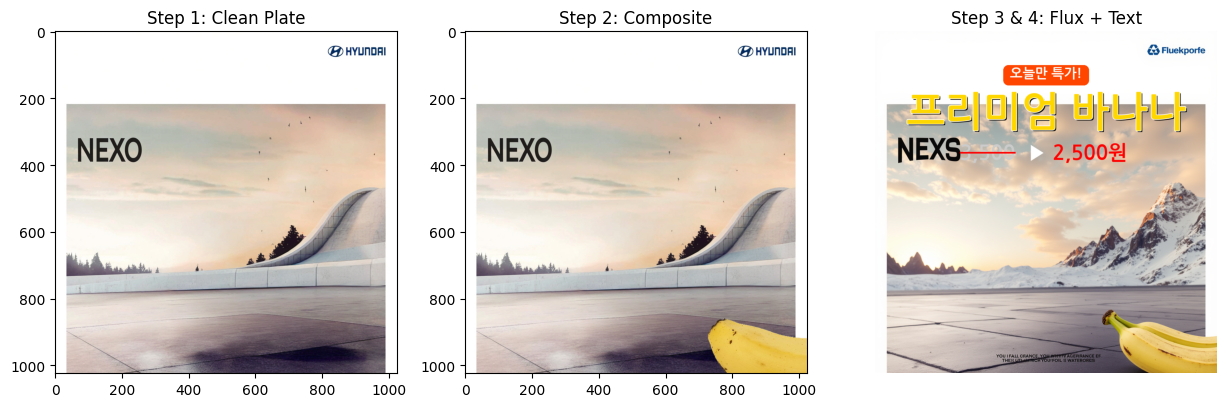

In [7]:
import torch
import gc
import os
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from torchvision import transforms
from transformers import AutoModelForImageSegmentation, DetrImageProcessor, DetrForObjectDetection, BitsAndBytesConfig
from diffusers import FluxImg2ImgPipeline, FluxTransformer2DModel, AutoPipelineForInpainting
from diffusers.utils import load_image
import matplotlib.pyplot as plt

# ==========================================
# ⚙️ 설정 (L4 GPU 최적화)
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16 # Flux는 bfloat16 권장

def flush():
    gc.collect()
    torch.cuda.empty_cache()

def download_font(font_name="NanumGothicBold.ttf"):
    if not os.path.exists(font_name):
        url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

# ==========================================
# 🔍 1. 자동차 감지 및 제거 (Clean Plate)
# ==========================================
def create_clean_plate(bg_path):
    print(f"🚗 [Step 1] '{bg_path}'에서 자동차 제거 중...")
    
    # 1-1. DETR로 자동차 마스크 따기
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
    model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
    
    image = load_image(bg_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]
    
    mask = Image.new("L", image.size, 0)
    draw = ImageDraw.Draw(mask)
    
    # 차, 버스, 트럭 감지
    for label, box in zip(results["labels"], results["boxes"]):
        if label in [3, 6, 8]: 
            box = [int(i) for i in box.tolist()]
            # 마스크를 조금 더 넓게 잡음 (여유 30px)
            draw.rectangle((box[0]-30, box[1]-30, box[2]+30, box[3]+30), fill=255)

    # 1-2. SDXL Inpainting으로 배경 채우기 (가볍고 빠름)
    # (Flux Inpainting은 무겁기 때문에 배경 지우기는 SDXL로 빠르게 처리)
    pipe = AutoPipelineForInpainting.from_pretrained(
        "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
        torch_dtype=torch.float16,
        variant="fp16"
    ).to(DEVICE)
    
    clean_bg = pipe(
        prompt="empty concrete pavement, sunset sky, wide angle, photorealistic, no car",
        negative_prompt="car, vehicle, tire",
        image=image,
        mask_image=mask,
        strength=0.99,
        num_inference_steps=30
    ).images[0]
    
    del pipe, model, processor
    flush()
    return clean_bg, mask

# ==========================================
# 🍌 2. 바나나 누끼 및 합성 (Layout Guide)
# ==========================================
def create_composite(clean_bg, banana_path, car_mask):
    print("🍌 [Step 2] 바나나 누끼 및 배치...")
    
    # 2-1. BiRefNet 누끼
    birefnet = AutoModelForImageSegmentation.from_pretrained("ZhengPeng7/BiRefNet", trust_remote_code=True)
    birefnet.to(DEVICE)
    
    banana_img = load_image(banana_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(banana_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        preds = birefnet(input_tensor)[-1].sigmoid().cpu()
    
    pred = preds[0].squeeze()
    mask = transforms.ToPILImage()(pred).resize(banana_img.size)
    mask = mask.point(lambda x: 255 if x > 128 else 0)
    banana_fg = banana_img.copy()
    banana_fg.putalpha(mask)
    
    del birefnet
    flush()
    
    # 2-2. 위치 잡기 (기존 차 위치 참고)
    mask_arr = np.array(car_mask)
    y_idx, x_idx = np.where(mask_arr > 0)
    
    if len(x_idx) > 0:
        x_min, x_max = np.min(x_idx), np.max(x_idx)
        y_min, y_max = np.min(y_idx), np.max(y_idx)
        car_w = x_max - x_min
        
        # 바나나 크기: 차 너비의 80%
        scale = (car_w * 0.8) / banana_fg.width
        new_w, new_h = int(banana_fg.width * scale), int(banana_fg.height * scale)
        banana_resized = banana_fg.resize((new_w, new_h), Image.LANCZOS)
        
        # 위치: 차가 있던 곳의 바닥 중앙
        pos_x = x_min + (car_w - new_w) // 2
        pos_y = y_max - new_h - 20 # 바닥에서 살짝 위
        
        composite = clean_bg.copy().convert("RGBA")
        composite.paste(banana_resized, (pos_x, pos_y), banana_resized)
        return composite.convert("RGB")
    else:
        print("⚠️ 차 위치 감지 실패, 중앙 배치")
        return clean_bg

# ==========================================
# ✨ 3. Flux Harmonization (L4 핵심 단계)
# ==========================================
def run_flux_polish(composite_image):
    print("✨ [Step 3] Flux AI 조명/질감 통합 (High Quality)...")
    
    # L4 메모리 절약을 위한 8bit 양자화 로드
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    
    transformer = FluxTransformer2DModel.from_pretrained(
        "black-forest-labs/FLUX.1-dev",
        subfolder="transformer",
        quantization_config=quant_config,
        torch_dtype=TORCH_DTYPE
    )
    
    pipe = FluxImg2ImgPipeline.from_pretrained(
        "black-forest-labs/FLUX.1-dev",
        transformer=transformer,
        torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload() # VRAM 부족 방지 (필수)
    
    # 프롬프트: 넥쏘 광고의 톤앤매너(Sunset, Concrete)를 유지하면서 바나나 묘사
    prompt = (
        "A giant fresh yellow banana sitting on a concrete pavement. "
        "Background is a stunning sunset sky with soft clouds. "
        "Cinematic lighting, warm golden hour light reflecting on the banana skin. "
        "Photorealistic, 8k, highly detailed, commercial photography. "
        "Wide angle shot, sharp focus."
    )
    
    # strength: 0.65~0.7 (합성한 티를 없애고 빛을 새로 그림)
    result = pipe(
        prompt=prompt,
        image=composite_image,
        strength=0.65, 
        guidance_scale=3.5,
        num_inference_steps=25,
    ).images[0]
    
    del pipe, transformer
    flush()
    return result

# ==========================================
# ✍️ 4. 텍스트 디자인 (가격표)
# ==========================================
def add_typography(image):
    print("✍️ [Step 4] 가격/할인 텍스트 합성...")
    draw = ImageDraw.Draw(image)
    W, H = image.size
    font_path = download_font()
    
    # 폰트 로드
    font_L = ImageFont.truetype(font_path, int(H*0.12)) # 대제목
    font_M = ImageFont.truetype(font_path, int(H*0.06)) # 가격
    font_S = ImageFont.truetype(font_path, int(H*0.04)) # 소제목
    
    # 텍스트 내용
    txt_main = "프리미엄 바나나"
    txt_sub = "오늘만 특가!"
    txt_price_old = "3,500"
    txt_price_new = "2,500원"
    
    # 유틸: 텍스트 너비 구하기
    def get_w(t, f): return draw.textbbox((0,0), t, font=f)[2]
    
    # 배치 계산 (상단 중앙)
    cy = H * 0.1
    
    # 1. 소제목 (오늘만 특가) - 캡슐 모양 배경
    w_sub = get_w(txt_sub, font_S)
    pad = 20
    draw.rounded_rectangle(
        [(W-w_sub)/2 - pad, cy, (W+w_sub)/2 + pad, cy + font_S.size + pad], 
        radius=15, fill="#FF4500"
    )
    draw.text(((W-w_sub)/2, cy+5), txt_sub, font=font_S, fill="white")
    
    cy += font_S.size + 40
    
    # 2. 대제목 (그림자 효과)
    w_main = get_w(txt_main, font_L)
    draw.text(((W-w_main)/2 + 4, cy + 4), txt_main, font=font_L, fill="black") # 그림자
    draw.text(((W-w_main)/2, cy), txt_main, font=font_L, fill="#FFD700", stroke_width=2, stroke_fill="white")
    
    cy += font_L.size + 30
    
    # 3. 가격 (취소선 -> 화살표 -> 할인가)
    full_price_str = f"{txt_price_old}  ▶  {txt_price_new}"
    w_price = get_w(full_price_str, font_M)
    start_x = (W - w_price) / 2
    
    # 3-1. 옛날 가격
    draw.text((start_x, cy), txt_price_old, font=font_M, fill="#CCC")
    # 취소선
    strike_w = get_w(txt_price_old, font_M)
    strike_y = cy + font_M.size/2
    draw.line([start_x, strike_y, start_x + strike_w, strike_y], fill="red", width=5)
    
    # 3-2. 화살표 및 새 가격
    cursor = start_x + strike_w + 20
    draw.text((cursor, cy), " ▶ ", font=font_M, fill="white")
    cursor += get_w(" ▶ ", font_M)
    draw.text((cursor, cy), txt_price_new, font=font_M, fill="red")

    return image

# ==========================================
# 🚀 실행
# ==========================================
def main(nexo_img, banana_img):
    flush()
    
    # 1. 배경 준비 (차 지우기)
    clean_bg, car_mask = create_clean_plate(nexo_img)
    
    # 2. 합성 가이드 (바나나 배치)
    composite = create_composite(clean_bg, banana_img, car_mask)
    
    # 3. Flux로 톤앤매너 통합 (가장 중요)
    final_art = run_flux_polish(composite)
    
    # 4. 텍스트 삽입
    final_ad = add_typography(final_art)
    
    # 저장 및 보기
    final_ad.save("flux_nexo_banana_ad.png")
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1); plt.imshow(clean_bg); plt.title("Step 1: Clean Plate")
    plt.subplot(1, 3, 2); plt.imshow(composite); plt.title("Step 2: Composite")
    plt.subplot(1, 3, 3); plt.imshow(final_ad); plt.title("Step 3 & 4: Flux + Text")
    plt.axis('off')
    plt.show()

#실행 (업로드된 파일명 사용)
main("template.png", "image.png")